In [ ]:
#load libraries
import os
import glob
from eumap import parallel
from eumap.raster import read_rasters, save_rasters
from eumap.misc import ttprint
from eumap.misc import find_files
import re/mnt/freya/julia/potential_fapar
import pandas as pd
import numpy as np
import rasterio
from pathlib import Path
from osgeo import gdal
import geopandas as gpd
import matplotlib.pyplot as plt
import random
from shapely.geometry import Polygon, Point
from eumap.mapper import SpaceOverlay
import matplotlib.pyplot as plt
import matplotlib
from random import sample
import joblib

In [ ]:
# read in training pts
training_pts = gpd.read_file('../data/training_pts/trg.pts_strata_13700_igh.drawn_epsg4326_v20230821.gpkg')
training_pts

In [ ]:
######original data for overlay
#make list of Paths to covariates (must be list containing Posix Paths)

##### overlay with topo
### overlay with topographic data
topo_file_vars = ["sine", "cosine", "up", "down", "_slope", "elevation", "cti", "neg.openess", "pos.openess", "vbf"]
topo_files = []
for i in topo_file_vars:
    grep_string = f"curl -s grep global | grep merit | grep dtm | grep {i}"
    string_ls = [str(url) for url in os.popen(grep_string).read().split('\n') if url.startswith('http')]
    for x in string_ls:
        topo_files.append(Path(x))

topo_files = list(set(topo_files))

# # overlay with floodmap
flood_string = glob.glob('static/*flood*hazard*.tif')

for i in flood_string:
    topo_files.append(Path(i))
len(topo_files )

print("topo_files: ", len(topo_files))

#litho files
grep_string =  "curl -s grep dtm_lithology | sort "
string_ls = [str(url) for url in os.popen(grep_string).read().split('\n') if url.startswith('http')]
litho_files = []
for i in string_ls:
    litho_files.append(Path(i))

litho_files = list(set(litho_files))
litho_files = [ x for x in litho_files if "ice" not in x.stem ]
litho_files = [ x for x in litho_files if "undefined" not in x.stem ]

print("litho_files: ", len(litho_files))

#landform files
grep_string =  "curl -s grep dtm_landform_usgs | grep _p_ | sort "
string_ls = [str(url) for url in os.popen(grep_string).read().split('\n') if url.startswith('http')]
landform_files = []
for i in string_ls:
    landform_files.append(Path(i))
landform_files
print("landform_files: ", len(landform_files))


#nightlight files
nl_part1 = glob.glob('../nightlights.average_viirs.v21_m_500m_s_*1_go_epsg4326_v20230318.tif')

nl_files = []
for i in nl_part1:
    nl_files.append(Path(i))

nl_files = list(set(nl_files))
print("nl_files: ", len(nl_files))

#hfp files
hfp_string1 = glob.glob('lcv_human.footprint_hpressure.50_m_1km_2*.tif')
add_string = glob.glob('lcv_human.footprint_hpressure.50_m_1km_2*.tif')

hfp_files = []
for i in hfp_string1:
    hfp_files.append(Path(i))
for i in add_string:
    hfp_files.append(Path(i))

hfp_files = list(set(hfp_files))
print("hfp_files: ", len(hfp_files))


#pop_count files
pop_count_string = glob.glob('pop_count/interpol/mosaic/*.tif')

pop_count_files = []
for i in pop_count_string:
    pop_count_files.append(Path(i))

print("pop_count_files: ", len(pop_count_files))

#crop_intensity files
# overlay with cropland intensity
cropint_string = np.sort(glob.glob("lcv_globalcropland_bowen.et.al_p_1km_s0..0cm_2*.tif"))
cropint_files = []
for i in cropint_string:
    cropint_files.append(Path(i))
    
add_string = glob.glob('lcv_globalcropland_bowen.et.al_p_1km_s0..0cm_2021_v0.1.tif')
cropint_files.append(Path(add_string[0]))

print("cropint_files: ", len(cropint_files))

#######climatic

#bioclim

# ### overlay with bioclim
grep_string = "curl -s grep .*global.*bioclim.*v2.1.*.tif"
string_ls = [str(url) for url in os.popen(grep_string).read().split('\n') if url.startswith('http')]
bioclim_files = []
for i in string_ls:
    bioclim_files.append(Path(i))
bio_vars= ['bio1_', 'bio2_', 'bio3','bio4','bio5','bio6','bio7','bio10','bio11','bio12','bio13','bio14','bio15','bio16','bio17','gsl','scd'] 
bioclim_files[:] = [url for url in bioclim_files if any(sub in url.stem for sub in bio_vars)]
bioclim_files

print("bioclim_files: ", len(bioclim_files))

#precipitation monthly accumulated
#files: 2000/01 - 2019/06
grep_string =  'curl -s grep global | grep clm_accum.precipitation | grep montlhy | grep _20'
string_ls = [str(url) for url in os.popen(grep_string).read().split('\n') if url.startswith('http')]

#copied files from previous year 2019/07 - 2020/12:
add_string = glob.glob('chelsa/pr/*.tif')

pr_files = []
for i in string_ls:
    pr_files.append(Path(i))
for i in add_string:
    pr_files.append(Path(i))

pr_monthly_ts_files = list(set(pr_files))

print("pr_monthly_ts_files: ", len(pr_monthly_ts_files))

# #precipitation annual log cumulative sum
pr_cumulative_part1 = glob.glob('CHELSA_cumpre/clm_precipitation_chelsea.annual.log_csum_1km_s0..0cm_2*.tif')

#copied files from previous year for 2020:
add_string = glob.glob('chelsa/pr_cumulative_sum/*.tif')

pr_cumulative_files = []
for i in pr_cumulative_part1:
    pr_cumulative_files.append(Path(i))
for i in add_string:
    pr_cumulative_files.append(Path(i))

pr_annual_ts_files = list(set(pr_cumulative_files))

print("pr_annual_ts_files: ", len(pr_annual_ts_files))

#precipitation monthly long-term
pr_longterm_part1 = glob.glob('chelsa/pr_longterm/*.tif')

pr_lt_files = []
for i in pr_longterm_part1:
    pr_lt_files.append(Path(i))

pr_monthly_lt_files = list(set(pr_lt_files))

print("pr_monthly_lt_files: ", len(pr_monthly_lt_files))

#tmin monthly ts
# overlay with chelsa tmin monthly
tmin_part1 = glob.glob('chelsa/chelsa_V2/GLOBAL/monthly/tasmin/CHELSA_tasmin_*_2*_V.2.1.tif')

#copied files from previous year for 2020:
add_string = glob.glob('chelsa/tasmin/*.tif')

tmin_files = []
for i in tmin_part1:
    tmin_files.append(Path(i))
for i in add_string:
    tmin_files.append(Path(i))

tmin_monthly_ts_files = list(set(tmin_files))

print("tmin_monthly_ts_files: ", len(tmin_monthly_ts_files))

#tmax monthly ts
tmax_part1 = glob.glob('chelsa/chelsa_V2/GLOBAL/monthly/tasmax/CHELSA_tasmax_*_2*_V.2.1.tif')

#copied files from previous year for 2020:
add_string = glob.glob('chelsa/tasmax/*.tif')

tmax_files = []
for i in tmax_part1:
    tmax_files.append(Path(i))
for i in add_string:
    tmax_files.append(Path(i))

tmax_monthly_ts_files = list(set(tmax_files))

print("tmax_monthly_ts_files: ", len(tmax_monthly_ts_files))

#taverage monthly ts
t_part1 = glob.glob('chelsa/chelsa_V2/GLOBAL/monthly/tas/CHELSA_tas_*_2*_V.2.1.tif')

#copied files from previous year for 2020:
add_string = glob.glob('chelsa/tas/*.tif')

t_files = []
for i in t_part1:
    t_files.append(Path(i))
for i in add_string:
    t_files.append(Path(i))

tavg_monthly_ts_files = list(set(t_files))
print("tavg_monthly_ts_files: ", len(tavg_monthly_ts_files))

#taverage monthly lt
tas_longterm_part1 = glob.glob('chelsa/tas_longterm/*.tif')

tas_lt_files = []
for i in tas_longterm_part1:
    tas_lt_files.append(Path(i))

tas_lt_files = list(set(tas_lt_files))

print("tas_lt_files: ", len(tas_lt_files))

# #vegetation indicators
forest_ind_string = glob.glob('forest_ind/forest.ind_esa.cci.lc_pc_250m_s_*_go_epsg4326_v20230627.tif')

forest_ind_files = []
for i in forest_ind_string:
    forest_ind_files.append(Path(i))

print("forest_ind_files: ", len(forest_ind_files))

crop_ind_string = glob.glob('cropland_ind/cropland.ind_esa.cci.lc_pc_250m_s_*_go_epsg4326_v20230627.tif')

crop_ind_files = []
for i in crop_ind_string:
    crop_ind_files.append(Path(i))

print("crop_ind_files: ", len(crop_ind_files))

wet_ind_string = glob.glob('wetland_ind/wetland.ind_esa.cci.lc_pc_250m_s_*_go_epsg4326_v20230627.tif')

wet_ind_files = []
for i in wet_ind_string:
    wet_ind_files.append(Path(i))

print("wet_ind_files: ", len(wet_ind_files))

grass_ind_string = glob.glob('grassland_ind/grassland.ind_esa.cci.lc_pc_250m_s_*_go_epsg4326_v20230627.tif')

grass_ind_files = []
for i in grass_ind_string:
    grass_ind_files.append(Path(i))

print("grass_ind_files: ", len(grass_ind_files))

shrub_ind_string = glob.glob('/lc_shrub_ind_mosaic/lc_shrubland_ind_mosaic_250m_*.tif')

shrub_ind_files = []
for i in shrub_ind_string:
    shrub_ind_files.append(Path(i))

print("shrub_ind_files: ", len(shrub_ind_files))

all_cov_files = pr_annual_ts_files + topo_files + litho_files + landform_files + nl_files + hfp_files + pop_count_files + cropint_files + bioclim_files  + pr_monthly_ts_files+ pr_monthly_lt_files + tmin_monthly_ts_files + tmax_monthly_ts_files + tavg_monthly_ts_files + tas_lt_files + forest_ind_files + crop_ind_files + wet_ind_files + grass_ind_files + shrub_ind_files

len(all_cov_files)

In [ ]:
# years and months to overlay
years = range(2000, 2021+1)
months = ['01', '02', '03','04', '05', '06', '07', '08', '09', '10', '11', '12']

In [ ]:
#space overlay with covariates
spc_overlay_fapar = SpaceOverlay(training_pts, fn_layers=all_cov_files)
# result_fapar = spc_overlay_fapar.run()

# geometric temp

In [ ]:
from datetime import datetime
doy_ls = []
for i in months:
    doy = (datetime.strptime(f'2000-{i}-15', '%Y-%m-%d').timetuple().tm_yday)
    doy_ls.append(doy)
doy_ls

In [ ]:
test_df = result_fapar.copy()

In [ ]:
import math
import numexpr as ne
from datetime import datetime
def geo_temp_max(fi, month, a=37.03043, b=-15.43029):
    f =fi
    pi = math.pi 
    doy = (datetime.strptime(f'2000-{month}-15', '%Y-%m-%d').timetuple().tm_yday)

    #math.cos((day - 18) * math.pi / 182.5 + math.pow(2, (1 - math.copysign(1, fi))) * math.pi) 
    sign = 'where(abs(fi) - fi == 0, 1, -1)'
    costeta = f"cos((doy - 18) * pi / 182.5 + 2**(1 - {sign}) * pi)"

    #math.cos(fi * math.pi / 180)
    cosfi = "cos(fi * pi / 180)"
    A = cosfi

    #(1 - costeta) * abs(math.sin(fi * math.pi / 180) )
    B = f"(1 - {costeta}) * abs(sin(fi * pi / 180) )"

    x = f"a * {A} + b * {B}"
    return ne.evaluate(x)

def geo_temp_min(fi, month, a=24.16453, b=-15.71751):
    f =fi
    pi = math.pi 
    doy = (datetime.strptime(f'2000-{month}-15', '%Y-%m-%d').timetuple().tm_yday)

    #math.cos((day - 18) * math.pi / 182.5 + math.pow(2, (1 - math.copysign(1, fi))) * math.pi) 
    sign = 'where(abs(fi) - fi == 0, 1, -1)'
    costeta = f"cos((doy - 18) * pi / 182.5 + 2**(1 - {sign}) * pi)"

    #math.cos(fi * math.pi / 180)
    cosfi = "cos(fi * pi / 180)"
    A = cosfi

    #(1 - costeta) * abs(math.sin(fi * math.pi / 180) )
    B = f"(1 - {costeta}) * abs(sin(fi * pi / 180) )"

    x = f"a * {A} + b * {B}"
    return ne.evaluate(x)

# elev_corr = 0.006 * 212
# (geo_temp(54.699870, 15)) - elev_corr

def calc_geomt(df):
    for i in months:
        df[f'geomt_max_{i}'] = df.apply(lambda x: geo_temp_max(x['lat_epsg4326'], i) - (0.006*x['dtm_elevation_merit.dem_m_250m_s0..0cm_2017_v1.0']), axis=1)
        df[f'geomt_min_{i}'] = df.apply(lambda x: geo_temp_min(x['lat_epsg4326'], i) - (0.006*x['dtm_elevation_merit.dem_m_250m_s0..0cm_2017_v1.0']), axis=1)
                                  
calc_geomt(test_df)

In [ ]:
objects = client.list_objects("global", prefix=f"fapar/")
fapar_names = []
for i in objects:
    strg = i.object_name
    fapar_names.append(strg)
fapar_files = ['data/' + x for x in fapar_names]
fapar_files = [x for x in fapar_files if '200001' not in x]
fapar_files = [x for x in fapar_files if '200002' not in x]
fapar_files = [x for x in fapar_files if '200003' not in x]
fapar_files = [Path(x) for x in fapar_files]
len(fapar_files)

In [ ]:
#space overlay strata
spc_overlay_strata_fapar = SpaceOverlay(test_df, fn_layers=fapar_files)
result_strata_fapar = spc_overlay_strata_fapar.run()

In [ ]:
#space overlay with water vapour
#....
objects = client.list_objects("global", prefix=f"wv/")
wv_names = []
for i in objects:
    strg = i.object_name
    wv_names.append(strg)
wv_files = ['global/' + x for x in wv_names]
wv_files = [x for x in wv_files if ".qa_" not in x]
wv_files = [x for x in wv_files if "_s_2022" not in x]
wv_files = [Path(x) for x in wv_files]
len(wv_files)

In [ ]:
spc_overlay_strata_wv = SpaceOverlay(result_strata_fapar, fn_layers=wv_files)
result_strata_wv = spc_overlay_strata_wv.run()

In [ ]:
#overlay with Whittaker smoothed fapar
fapar_whittaker_pre = glob.glob('whittaker/*.tif')

fapar_whittaker_pre_files = []
for i in fapar_whittaker_pre:
    fapar_whittaker_pre_files.append(Path(i))

fapar_whittaker_pre_files = list(set(fapar_whittaker_pre_files))

print("fapar_whittaker_pre_files: ", len(fapar_whittaker_pre_files))

In [ ]:
spc_overlay_strata_wtfapar = SpaceOverlay(result_strata_wv, fn_layers=fapar_whittaker_pre_files)
result_strata_wtfapar = spc_overlay_strata_wtfapar.run()

In [ ]:
#remove points if NaN in any FAPAR or DTM file
result_strata_wtfapar_nan = result_strata_wtfapar.copy()
fapar_cols = [x for x in result_strata_wtfapar.columns if 'fapar' in x]

fapar_cols = [x for x in fapar_cols if 'whittaker' not in x]

dtm_cols = [x for x in result_strata_wtfapar.columns if 'merit' in x]

for i in fapar_cols:
    result_strata_wtfapar_nan = result_strata_wtfapar_nan.dropna(subset=[i])
    print(len(result_strata_wtfapar_nan))
    
for i in dtm_cols:
    result_strata_wtfapar_nan = result_strata_wtfapar_nan.dropna(subset=[i])

# add EVI and LST overlay files

In [ ]:
#get EVI layers

grep_string =  "curl -s grep global | grep evi | grep p50 | grep 0cm_2 | grep 01..2 | grep v061_p50"
string_ls = [str(url) for url in os.popen(grep_string).read().split('\n') if url.startswith('http')]

evi_files = []
for i in string_ls:
    evi_files.append(Path(i))
evi_files = list(set(evi_files))

print("evi_files: ", len(evi_files))
# evi_files

# get lst layers p50 day and night
grep_string =  "curl -s grep global | grep lst | grep p50 | grep time_p50 | grep 01..2"
string_ls = [str(url) for url in os.popen(grep_string).read().split('\n') if url.startswith('http')]

lst_files = []
for i in string_ls:
    lst_files.append(Path(i))
lst_files = list(set(lst_files))

print("lst_files: ", len(lst_files))
# lst_files

In [ ]:
# #space overlay with covariates
overlay_files = evi_files + lst_files

spc_overlay_evi = SpaceOverlay(result_strata_wtfapar_nan, fn_layers=overlay_files)
result_evi = spc_overlay_evi.run()

In [ ]:
#get fapar_files from fapar columns
fapar_files = [x for x in result_strata_wtfapar_nan.columns if 'fapar' in x]
fapar_files = [x for x in fapar_files if 'whittaker' not in x]
fapar_files = [Path('dummy_path/'+x+".tif") for x in fapar_files]
fapar_files


In [ ]:
fapar_p50_files = [x for x in fapar_files if 'p50' in x.stem]
fapar_p05_files = [x for x in fapar_files if 'p05' in x.stem]
fapar_p95_files = [x for x in fapar_files if 'p95' in x.stem]
print(len(fapar_p50_files),len(fapar_p05_files), len(fapar_p95_files))

In [ ]:
#remove _c_ file from lithology variables (because classes, not probability)
lith_files_corr = [x for x in litho_files if "_c_" not in x.stem]

In [ ]:
wv_files_m = [x for x in wv_files if "_m_" in x.stem]
len(wv_files_m)

In [ ]:
pnts = result_strata_wtfapar_nan.copy()
pnts.drop(columns=['dtm_lithology_usgs.ecotapestry_c_250m_s0..0cm_2014_v1.0'], inplace = True)
#to test

pnts['lon'] = pnts['geometry'].x
pnts['lat'] = pnts['geometry'].y
pnts['lcv_globalcropland_bowen.et.al_p_1km_s0..0cm_2021_v0.1'] = pnts['lcv_globalcropland_bowen.et.al_p_1km_s0..0cm_2020_v0.1']

mon_word = ['jan','feb','mar','apr','may','jun','jul','aug','sep','oct','nov','dec']
mon = ['01','02','03','04','05','06','07','08','09','10','11','12']

topo_vars = ["dtm_slope", "dtm_aspect-cosine", "dtm_aspect-sine", "dtm_downlslope.curvature", "dtm_upslope.curvature", "dtm_elevation", "dtm_cti", "dtm_neg.openess", "dtm_pos.openess", "dtm_vbf"]
lith_vars = [i.stem.split("ecotapestry.")[1].split("_p")[0] for i in lith_files_corr]
landform_vars = [i.stem.split("ecotapestry.")[1].split("_p")[0] for i in landform_files]
bioclim_vars = [i.stem.split("chelsa.")[1].split("_m")[0] for i in bioclim_files]

# var_ls = ['year', 'month', 'fapar_p50', 'fapar_p05', 'fapar_p95', 'hfp'] + bioclim_vars + topo_vars + lith_vars + landform_vars + 


var_ls = ['fapar_p50', 'fapar_p05', 'fapar_p95', 'hfp', 'pop_count', 'bio10',
       'bio11', 'bio12', 'bio13', 'bio14', 'bio15', 'bio16', 'bio17', 'bio1',
       'bio2', 'bio3', 'bio4', 'bio5', 'bio6', 'bio7', 'gsl', 'scd',
       'dtm_slope', 'dtm_aspect-cosine', 'dtm_aspect-sine',
       'dtm_downlslope.curvature', 'dtm_upslope.curvature', 'dtm_elevation',
       'dtm_cti', 'dtm_neg.openess', 'dtm_pos.openess', 'dtm_vbf',
       'basic.plutonics', 'siliciclastic.sedimentary',
       'intermediate.plutonics', 'acid.volcanic', 'metamorphics',
       'intermediate.volcanics', 'unconsolidated.sediment',
       'carbonate.sedimentary.rock', 'acid.plutonics', 'pyroclastics',
       'mixed.sedimentary.rock', 'evaporite', 'basic.volcanics',
       'breaks.foothills', 'flat.plains', 'high.mountains.deep.canyons',
       'hills', 'low.hills', 'low.mountains', 'smooth.plains',
       'crop_intensity', 'forest_ind', 'cropland_ind', 'grassland_ind',
       'wetland_ind', 'shrubland_ind', 'year', 'month', 'geomt_max',
       'geomt_min', 'geomt_gap_maxmin', 'flood_hazard', 'accum_pr_monthly',
       'log_csum_pr_annual', 'tmin_monthly', 'tmax_monthly', 'tas_monthly',
       'nightlights', 'wv_monthly_lt_p50', 'wv_monthly_lt_p25',
       'wv_monthly_lt_p75', 'wv_monthly_lt_sd', 'wv_monthly_ts_raw',
       'wv_monthly_ts_smooth', 'tas_lt_monthly', 'pr_lt_monthly', 'lat', 'lon',
       'id', 'stratum', 'diff_tasactual_longterm', 'diff_practual_longterm']


df_pnts = pd.DataFrame(columns=var_ls)
df_pnts.loc[0] = 0

for i in bioclim_files:    
    old_col = i.stem
    new_col = i.stem.split('chelsa.')[1].split('_')[0]
    pnts.rename(columns={old_col:new_col}, inplace=True)  

for i in topo_files:    
    old_col = i.stem
    new_col = i.stem.split('_merit')[0]
    pnts.rename(columns={old_col:new_col}, inplace=True)
    
for i in lith_files_corr:    
    old_col = i.stem
    new_col = i.stem.split("ecotapestry.")[1].split("_p")[0]
    pnts.rename(columns={old_col:new_col}, inplace=True)
    
for i in landform_files:    
    old_col = i.stem
    new_col = i.stem.split("ecotapestry.")[1].split("_p")[0]
    pnts.rename(columns={old_col:new_col}, inplace=True)

    
#rename water vapour files to get rid of month days
for i in range(len(wv_files)):
    old_col = wv_files[i].stem
    new_col = old_col.replace("30_", "xx_" )
    new_col = new_col.replace("28_", "xx_" )
    new_col = new_col.replace("29_", "xx_" )
    new_col = new_col.replace("31_", "xx_" )
    pnts.rename(columns={old_col:new_col}, inplace=True)

    
#rename water vapour files to get rid of month days
for i in range(len(fapar_whittaker_pre_files)):
    old_col = fapar_whittaker_pre_files[i].stem
    new_col = old_col.replace("30_", "xx_" )
    new_col = new_col.replace("28_", "xx_" )
    new_col = new_col.replace("29_", "xx_" )
    new_col = new_col.replace("31_", "xx_" )
    pnts.rename(columns={old_col:new_col}, inplace=True)
    
#rename water vapour files to get rid of month days
for i in range(len(evi_files)):
    old_col = evi_files[i].stem
    new_col = old_col.replace("30_", "xx_" )
    new_col = new_col.replace("28_", "xx_" )
    new_col = new_col.replace("29_", "xx_" )
    new_col = new_col.replace("31_", "xx_" )
    pnts.rename(columns={old_col:new_col}, inplace=True)
    
#rename water vapour files to get rid of month days
for i in range(len(lst_files)):
    old_col = lst_files[i].stem
    new_col = old_col.replace("30_", "xx_" )
    new_col = new_col.replace("28_", "xx_" )
    new_col = new_col.replace("29_", "xx_" )
    new_col = new_col.replace("31_", "xx_" )
    pnts.rename(columns={old_col:new_col}, inplace=True)
    
for i in range(len(pr_files)):
    old_col = pr_files[i].stem
    new_col = old_col.replace(".30", ".xx" )
    new_col = new_col.replace(".28", ".xx" )
    new_col = new_col.replace(".31", ".xx" )
    pnts.rename(columns={old_col:new_col}, inplace=True)

for i in range(len(fapar_p50_files)):
    print("round", i)
    month = str(fapar_p50_files[i].stem.split('_')[5][4:6])
    year = str(fapar_p50_files[i].stem.split('_')[5][0:4])
    fapar_p50 = str(fapar_p50_files[i].stem)
    fapar_p05 = str(fapar_p05_files[i].stem)
    fapar_p95 = str(fapar_p95_files[i].stem)

    df_temp = pnts[[fapar_p50, fapar_p05,fapar_p95]]
    df_temp = df_temp.rename(columns={fapar_p50: 'fapar_p50', fapar_p05: 'fapar_p05', fapar_p95: 'fapar_p95'})
    df_temp['hfp'] = pnts[f'lcv_human.footprint_hpressure.50_m_1km_{year}_epsg4326_v1.0']
    df_temp["pop_count"] = pnts[f'pop.count_ghs.jrc_m_100m_s_{year}0101_{year}1231_go_epsg.4326_v20230620']
    for bio in bioclim_vars:
        df_temp[bio] = pnts[bio]
    for topo in topo_vars:
        df_temp[topo] = pnts[topo]
    for litho in lith_vars:
        df_temp[litho] = pnts[litho].replace({np.nan: 0}) 
    for landform in landform_vars:
        df_temp[landform] = pnts[landform].replace({np.nan: 0})          
    df_temp["crop_intensity"] = pnts[f'lcv_globalcropland_bowen.et.al_p_1km_s0..0cm_{year}_v0.1']
    df_temp["evi"] = pnts[f'veg_evi_mod13q1.v061_p50_250m_s0..0cm_{year}.{month}.01..{year}.{month}.xx_v1.0']
    df_temp["lst_day"] = pnts[f'clm_lst_mod11a2.daytime_p50_1km_s0..0cm_{year}.{month}.01..{year}.{month}.xx_v1.2']
    df_temp["lst_night"] = pnts[f'clm_lst_mod11a2.nighttime_p50_1km_s0..0cm_{year}.{month}.01..{year}.{month}.xx_v1.2']
    df_temp["forest_ind"] = pnts[f'forest.ind_esa.cci.lc_pc_250m_s_{year}0101_{year}1231_go_epsg4326_v20230627'].replace({np.nan: 0})
    df_temp["cropland_ind"] = pnts[f'cropland.ind_esa.cci.lc_pc_250m_s_{year}0101_{year}1231_go_epsg4326_v20230627'].replace({np.nan: 0})
    df_temp["grassland_ind"] = pnts[f'grassland.ind_esa.cci.lc_pc_250m_s_{year}0101_{year}1231_go_epsg4326_v20230627'].replace({np.nan: 0})
    df_temp["wetland_ind"] = pnts[f'wetland.ind_esa.cci.lc_pc_250m_s_{year}0101_{year}1231_go_epsg4326_v20230627'].replace({np.nan: 0})
    df_temp["shrubland_ind"] = pnts[f'lc_shrubland_ind_mosaic_250m_{year}'].replace({np.nan: 0})
    df_temp["fapar_p95_smooth"] = pnts[f'fapar_essd.lstm.whittaker_p95_250m_s_{year}{month}01_{year}{month}xx_go_epsg.4326_v20230628'].replace({np.nan: 255})
    df_temp['year'] = year
    df_temp['month'] = month
    df_temp['geomt_max'] = pnts[f'geomt_max_{month}']
    df_temp['geomt_min'] = pnts[f'geomt_min_{month}']
    df_temp['geomt_gap_maxmin'] = df_temp['geomt_max'] - df_temp['geomt_min']
    df_temp["flood_hazard"] = pnts['dtm_floodmap.500y_jrc.hazardmapping_m_1km_s0..0cm_1500..2016_v1.0'].replace({np.nan: 0})
    df_temp['accum_pr_monthly'] = pnts[f'clm_accum.precipitation_chelsa.montlhy_m_1km_s0..0cm_{year}.{month}.01..{year}.{month}.xx_v2.1']
    df_temp['log_csum_pr_annual'] = pnts[f'clm_precipitation_chelsea.annual.log_csum_1km_s0..0cm_{year}_v2.1']
    df_temp['tmin_monthly'] = pnts[f'CHELSA_tasmin_{month}_{year}_V.2.1']
    df_temp['tmax_monthly'] = pnts[f'CHELSA_tasmax_{month}_{year}_V.2.1']
    df_temp['tas_monthly'] = pnts[f'CHELSA_tas_{month}_{year}_V.2.1']*0.1-273.15
    df_temp["nightlights"] = pnts[f'nightlights.average_viirs.v21_m_500m_s_{year}0101_{year}1231_go_epsg4326_v20230318'].replace({np.nan: 0})
    df_temp['wv_monthly_lt_p50'] = pnts[f'wv_mcd19a2v061.seasconv.m.m{month}_p50_1km_s_20000101_202212xx_go_epsg.4326_v20230619']
    df_temp['wv_monthly_lt_p25'] = pnts[f'wv_mcd19a2v061.seasconv.m.m{month}_p25_1km_s_20000101_202212xx_go_epsg.4326_v20230619']
    df_temp['wv_monthly_lt_p75'] = pnts[f'wv_mcd19a2v061.seasconv.m.m{month}_p75_1km_s_20000101_202212xx_go_epsg.4326_v20230619']
    df_temp['wv_monthly_lt_sd'] = pnts[f'wv_mcd19a2v061.seasconv.m.m{month}_sd_1km_s_20000101_202212xx_go_epsg.4326_v20230619']
    df_temp['wv_monthly_ts_raw'] = pnts[f'wv_mcd19a2v061.seasconv_m_1km_s_{year}{month}01_{year}{month}xx_go_epsg.4326_v20230619']
    df_temp['wv_monthly_ts_smooth'] = pnts[f'wv_mcd19a2v061.seasconv.whittaker_m_1km_s_{year}{month}01_{year}{month}xx_go_epsg.4326_v20230619']
    df_temp['wv_yearly_p25'] = pnts[f'wv_mcd19a2v061.seasconv.m.yearly_p25_1km_s_{year}0101_{year}12xx_go_epsg.4326_v20230619']
    df_temp['wv_yearly_p50'] = pnts[f'wv_mcd19a2v061.seasconv.m.yearly_p50_1km_s_{year}0101_{year}12xx_go_epsg.4326_v20230619']
    df_temp['wv_yearly_p75'] = pnts[f'wv_mcd19a2v061.seasconv.m.yearly_p75_1km_s_{year}0101_{year}12xx_go_epsg.4326_v20230619']
    df_temp['tas_lt_monthly'] = pnts[f'CHELSA_tas_{month}_1981-2010_V.2.1']*0.1-273.15 
    df_temp['pr_lt_monthly'] = pnts[f'CHELSA_pr_{month}_1981-2010_V.2.1']
    df_temp['lat'] = pnts['lat']
    df_temp['lon'] = pnts['lon']
    df_temp['id'] = pnts['overlay_id']
    df_temp['stratum'] = pnts['stratum']
    df_temp['diff_tasactual_longterm'] = df_temp['tas_lt_monthly'] - df_temp["tas_monthly"]
    df_temp['diff_practual_longterm'] = df_temp['pr_lt_monthly'] - df_temp["accum_pr_monthly"]
    print('concatenating...')

    df_pnts = pd.concat([df_pnts, df_temp], ignore_index=True)

df_pnts = df_pnts.drop([0])
df_pnts_clean = df_pnts.dropna()
df_pnts_clean

In [ ]:
fapar_p50 = str(fapar_p50_files[0].stem)
fapar_p50

In [ ]:
all_cols_except_fapar = [k for k in list(df_pnts_clean.columns) if k not in ["fapar_p50", "fapar_p05", "fapar_p95"]]
all_cols_except_fapar
df = df_pnts_clean.copy()
df_melted = df.melt(id_vars=all_cols_except_fapar, 
        var_name="fapar_q", 
        value_name="fapar_value")
df_melted['fapar_q'] = df_melted['fapar_q'].str[-2:]
df_melted

In [ ]:
#save to file data including EVI and LST
outpath = 'melted_sp_overlay_trgpts_fapar_v20230918.lz4'
# joblib.dump(df_melted, outpath, compress='lz4')

# density plots

In [ ]:
import math
df_melted_12500 = df_melted.copy()
df_melted_12500["log_evi"] = np.log(df_melted_12500.evi+1)
df_melted_12500["log_accum_pr_monthly"] = np.log((df_melted_12500.accum_pr_monthly.astype("float64"))+1)
df_melted_12500["log_lst_day"] = np.log((df_melted_12500.lst_day+1)) #.astype("float64"))
df_melted_12500["log_nightlights"] = np.log((df_melted_12500.nightlights.astype("float64"))+1)
df_melted_12500["log_hfp"] = np.log((df_melted_12500.hfp.astype("float64"))+1)
df_melted_12500["log_pop_count"] = np.log((df_melted_12500.pop_count.astype("float64"))+1)
df_melted_12500["log_crop_intensity"] = np.log((df_melted_12500.crop_intensity.astype("float64"))+1)
df_melted_12500["log_pr_lt_monthly"] = np.log(((100*df_melted_12500.pr_lt_monthly.astype("float64")))+1)
df_melted_12500["fapar_value_sc"] = df_melted_12500.fapar_value * 0.004
df_melted_12500["lst_day_sc"] = df_melted_12500.lst_day*0.02-273.15
df_melted_12500["evi_sc"] = df_melted_12500.evi/10000

In [ ]:
from scipy.stats.stats import pearsonr    
df_melted_12500_p50 = df_melted_12500[df_melted_12500.fapar_q == "50"]
df_melted_12500_p95 = df_melted_12500[df_melted_12500.fapar_q == "95"]
df_melted_12500_p05 = df_melted_12500[df_melted_12500.fapar_q == "05"]
len(df_melted_12500_p50)

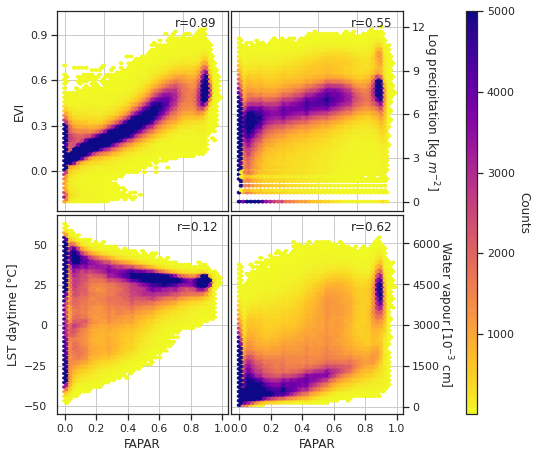

In [109]:
#density plots
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
import matplotlib.ticker as ticker
from mpl_toolkits.axes_grid1 import make_axes_locatable 

sns.set()
sns.set_theme(style='white')

f = plt.figure(figsize = (8,8))
f.tight_layout()
data = df_melted_12500_p50

# plt.subplot(221)
ax = f.add_subplot(221)

plt.hexbin(data=data, x='fapar_value_sc', y='evi_sc', gridsize=(40, 40) , cmap = 'plasma_r', mincnt=5, vmax = 5000, xscale =25, yscale = 25)
# plt.title('SepalLength vs SepalWidth')
plt.xlabel('FAPAR')
ax.set_xticklabels([])
# ax.get_xaxis().set_visible(False)
ax.tick_params(axis='x', direction = 'out')
# plt.ylim(0, 10)
ax.grid(True)
# ax.set_yscale("log")
plt.ylabel('EVI')
plt.text(0.7,0.95, f"r={round(pearsonr(data['fapar_value_sc'], data['evi_sc'])[0], 2)}")
# plt.ylim(0, 10)
# Create your ticker object with M ticks
# M = 4
# yticks = ticker.MaxNLocator(M)
# Set the yaxis major locator using your ticker object. You can also choose the minor
# tick positions with set_minor_locator.
# ax.yaxis.set_major_locator(yticks)
nBins = 5
ax.yaxis.set_major_locator(ticker.MaxNLocator(nbins=nBins, min_n_ticks=nBins-1))
# ax.set_yticks([0, 2, 4, 6, 8], minor=False)
ax.yaxis.tick_left()


ax2 = f.add_subplot(222)
ax2.yaxis.tick_right()
plt.hexbin(data=data, x='fapar_value_sc', y='log_accum_pr_monthly', gridsize=(40, 40) , cmap = 'plasma_r', mincnt=5, vmax =5000, xscale =25, yscale = 25)
# plt.title('SepalLength vs SepalWidth')
# plt.xlabel('SepalLength (cm)')
plt.tick_params(axis='both', which='both')
# plt.ylim(0, 10)
yl = ax2.set_ylabel(r"Log precipitation [kg $m^{-2}$]", rotation=-90,labelpad=15)
plt.text(x=0.7, y=0.92, transform=ax2.transAxes, s= f"r={round(pearsonr(data['fapar_value_sc'], data['log_accum_pr_monthly'])[0], 2)}")

# ax2.get_xaxis().set_visible(False)
ax2.set_xticklabels([])
# ax.xaxis.label.set_color('white')
ax2.yaxis.set_label_position("right")
# ax.yaxis.set_label_position("right")
# plt.ylabel('modis_evi (cm)')
ax2.grid(True)
# ax2.yaxis.set_major_locator(yticks)
ax2.yaxis.set_major_locator(ticker.MaxNLocator(nbins=nBins, min_n_ticks=nBins-1))
# ax2.set_yticks([0, 2, 4, 6, 8], minor=False)
ax2.yaxis.tick_right()


ax3 = f.add_subplot(223)
ax3.xaxis.tick_bottom()
plt.hexbin(data=data, x='fapar_value_sc', y='lst_day_sc', gridsize=(40, 40) , cmap = 'plasma_r', mincnt=5, vmax = 5000) #, xscale =25, yscale = 25
# plt.title('SepalLength vs SepalWidth')
# plt.ylim(0, 16000)
# plt.locator_params(axis='y', nbins=10)
# ax3.yaxis.tick_left()
tick_spacing=0.2
ax3.xaxis.set_major_locator(ticker.MultipleLocator(tick_spacing))
ax3.grid(True)
# ax3.yaxis.set_label_position("left")
# ax3.yaxis.set_major_locator(yticks)
ax3.yaxis.set_major_locator(ticker.MaxNLocator(nbins=nBins, min_n_ticks=nBins-1))
plt.text(x=0.7, y=0.92, transform=ax3.transAxes, s=f"r={round(pearsonr(data['fapar_value_sc'], data['lst_day_sc'])[0], 2)}")

plt.xlabel('FAPAR')
plt.ylabel('LST daytime [°C]')
# plt.ylim(0, 10)
# ax3.yaxis.tick_left()
# ax3.set_yticks([0, 2, 4, 6, 8], minor=False)


ax4 = f.add_subplot(224)
ax4.yaxis.tick_right()
ax4.xaxis.tick_bottom()
plt4 = plt.hexbin(data=data, x='fapar_value_sc', y='wv_monthly_ts_smooth', gridsize=(40, 40) , cmap = 'plasma_r', mincnt=5, vmax = 5000) #, xscale =25, yscale = 25
# plt.title('SepalLength vs SepalWidth')
plt.xlabel('FAPAR')
ax4.grid(True)
yl = ax4.set_ylabel(r"Water vapour [$10^{-3}$ cm]", rotation=-90,labelpad=15)
plt.text(x=0.7, y=0.92, transform=ax4.transAxes, s=f"r={round(pearsonr(data['fapar_value_sc'], data['wv_monthly_ts_smooth'])[0], 2)}")
ax4.yaxis.set_label_position("right")
# plt.locator_params(axis='y', nbins=5)
# ax4.yaxis.set_major_locator(yticks)
# ax4.set_yticks([0, 2, 4, 6, 8], minor=False)
# plt.ylim(0, 1000)
ax4.yaxis.set_major_locator(ticker.MaxNLocator(nbins=nBins, min_n_ticks=nBins-1))

ax4.xaxis.set_major_locator(ticker.MultipleLocator(tick_spacing))

#Now, create a common legend
cbar_ax = f.add_axes([0.91, 0.2, 0.02, 0.7])  # Adjust the position and size as needed
cb = plt.colorbar(plt4, cax=cbar_ax)

# # # Set the label for the colorbar
cb.set_label('Counts', rotation=-90, labelpad=15)

plt.subplots_adjust(left=0.2,
                    bottom=0.2,
                    right=0.8,
                    top=0.9,
                    wspace=0.02,
                    hspace=0.02)

plt.show()

